## Dataset is Exremely Balanced

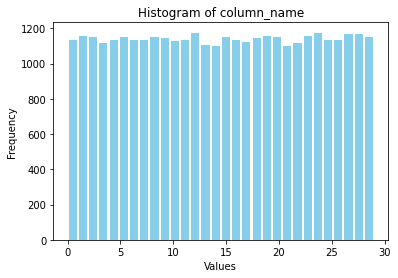

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file_y='/kaggle/input/col774-2022/train_y.csv'
dataY = pd.read_csv(csv_file_y)
# print(dataY)

# l=[0 for i in range(30)]
# for i in dataY['Genre']:
#     l[i]+=1
# print(l)
# Plotting the histogram
dataY['Genre'].plot(kind='hist', bins=30, rwidth=0.8, color='skyblue')

# Display the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of column_name')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch.nn as nn
import torch.nn.functional as AF
from transformers import BertTokenizer, BertModel
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm  # Import tqdm for progress tracking
import re

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Custom dataset class for our image data
class BookTitleDataset(Dataset):
    def __init__(self, csv_file_x, csv_file_y, tokenizer, max_title_len, root_dir, transforms=None):
        dataX = pd.read_csv(csv_file_x)
        dataY = pd.read_csv(csv_file_y)
        data = pd.merge(dataX, dataY, on='Id')
        del dataX
        del dataY
        title = data.iloc[:, 2]
        self.x = title
        self.y = data.iloc[:, -1]
        self.tokenizer = tokenizer
        self.length = len(self.y)
        self.max_title_len = max_title_len
        self.annotations = data
        self.root_dir = root_dir
        self.transforms = transforms
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index): 
        imgPath = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = Image.open(imgPath)
        if self.transforms:
            image = self.transforms(image)
        x = self.x[index]
        y = self.y[index]
        x = self.tokenizer(x, padding='max_length', max_length=self.max_title_len, truncation=True,
                           return_tensors="pt")
        return (image, x, y)

    
    
    
    
    
    
class Bert(nn.Module):
    def __init__(self, dropout=0.3):
        super(Bert, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')

    def forward(self, input_id, mask):
        embeddings, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        return embeddings


class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.model.avgpool = nn.Identity()
        self.model.fc =  nn.Identity()
        self.finalLayer = nn.Conv2d(512, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    
    def forward(self, image):
        ret = self.model(image)
        ret = ret.reshape(ret.shape[0], 512, 7, 7)
        ret = self.finalLayer(ret)
        ret = ret.reshape(ret.shape[0], 768, 49).permute(0, 2, 1)
        return ret
    
    
class Res_Bert(nn.Module):
    def __init__(self):
        super(Res_Bert, self).__init__()
        self.modelB = Bert()
        self.modelA = Resnet18()
        self.layerNorm = nn.LayerNorm(768)
        self.dropout = nn.Dropout(0.3)
        self.crossAttention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.downsample = nn.AdaptiveAvgPool1d(1)
        # self.classifier = nn.Linear(768, 30)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(256, 30)
        )

    def forward(self, image, mask, input_id):
        x1 = self.modelA(image)
        x2 = self.modelB(input_id, mask)
        
        query = x2
        key = x1
        value = x1
        attention = self.apply_crossAttention(query, key, value)
        x2 = attention[0] + x2
        x2 = self.dropout(x2) 
        x2 = x2.permute(0, 2, 1)
        x2 = self.downsample(x2)
        x2 = x2.view(x2.size(0), -1)
        x2 = self.dropout(x2) 
        x = self.classifier(x2)
        return x
    
    def apply_crossAttention(self, q, k, v):
        # Shapes of q, k, v:
        # q: [batch_size, 61, 768], k: [batch_size, 49, 768], v: [batch_size, 49, 768]
        q_att = self.layerNorm(q)  # [32, 61, 768]
        k_att = self.layerNorm(k)  # [32, 49, 768]
        v_att = self.layerNorm(v)  # [32, 49, 768]
        # Apply cross-attention block: q_att attends to k_att and v_att
        att_out, att_map = self.crossAttention(q_att, k_att, v_att)
        # Layer normalization on the output
        att_out = self.layerNorm(att_out)  # [32, 61, 768]
#         print(att_map.shape)
        return att_out, att_map

    
    
    
    
    
    
    
def train(ep=5):
    # Training loop
    for epoch in range(ep):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{ep}")
        for i, (img, embed, target) in enumerate(pbar):
            img = img.to(device)
            mask = embed['attention_mask'].to(device)
            input_id = embed['input_ids'].squeeze(1).to(device)
            target = target.to(device)

            out = model(img, mask, input_id)
#             break
#         break
            loss = lossFunction(out, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({'loss': loss.item()})

        print(f'Epoch {epoch + 1} finished with loss: {loss.item()}')
        # save(f'ver{epoch}')
        save_checkpoint(model, optimizer, epoch, f'ver{epoch}')

        # Calculate training and testing accuracy and metrics
        y_true_train, y_pred_train = calculate_metrics(train_loader)
        print("Training Metrics:")
        print_metrics(y_true_train, y_pred_train)

        y_true_test, y_pred_test = calculate_metrics(test_loader)
        print("Testing Metrics:")
        print_metrics(y_true_test, y_pred_test)




#----------------------------------------------------------HELPER FUNCTOINS-----------------------------------------------------
def save_checkpoint(model, optimizer, epoch, file_name):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, file_name)
    print(f"Checkpoint saved to {file_name}")


def load_checkpoint(file_name, model, optimizer, resumeTraining = True):
    checkpoint = torch.load(file_name)
    # Load model and optimizer state_dict
    model.load_state_dict(checkpoint['model_state_dict'])
    if(resumeTraining):
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # Load epoch value
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming from epoch {epoch}")
        return model, epoch, optimizer
    return model


def calculate_metrics(loader):
    all_preds = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for img, embed, target in tqdm(loader, desc="Calculating Metrics"):
            img = img.to(device)
            mask = embed['attention_mask'].to(device)
            input_id = embed['input_ids'].squeeze(1).to(device)
            target = target.to(device)

            out = model(img, mask, input_id)
            all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return np.array(all_targets), np.array(all_preds)

def print_metrics(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))




# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
learning_rate = 5e-5
batch_size = 32  

# Calculated mean and std of the entire data separately
mean = torch.tensor([0.5482, 0.5109, 0.4749])
std = torch.tensor([0.2526, 0.2428, 0.2356])

# Defining a custom transform pipeline
train_transform = transforms.Compose([
    transforms.RandomInvert(0.6),
    transforms.RandomSolarize(0.6),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    transforms.Normalize(mean=mean, std=std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std), 
])

training_data = BookTitleDataset(csv_file_x='/kaggle/input/col774-2022/train_x.csv',
                                  csv_file_y='/kaggle/input/col774-2022/train_y.csv',
                                  root_dir='/kaggle/input/col774-2022/images/images',
                                  tokenizer=tokenizer, max_title_len=61, transforms=train_transform)

testing_data = BookTitleDataset(csv_file_x='/kaggle/input/col774-2022/non_comp_test_x.csv',
                                 csv_file_y='/kaggle/input/col774-2022/non_comp_test_y.csv',
                                 root_dir='/kaggle/input/col774-2022/images/images',
                                 tokenizer=tokenizer, max_title_len=61, transforms=test_transform)

train_loader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=os.cpu_count())
test_loader = DataLoader(dataset=testing_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=os.cpu_count())    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Res_Bert()
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
    # discriminator = nn.DataParallel(discriminator)

# load('ver4')
model = model.to(device)
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)

train(ep=5)


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Using 2 GPUs.


Epoch 1/5: 100%|██████████| 1069/1069 [07:20<00:00,  2.43it/s, loss=1.32]


Epoch 1 finished with loss: 1.3197673559188843


Calculating Metrics: 100%|██████████| 1069/1069 [02:25<00:00,  7.33it/s]


Training Metrics:
Confusion Matrix:
[[1051    1    0    1    2    0   13    0    5    1    5    2   15    0
     1    0    5    0    7    1    2    0    1   12    0    2    6    0
     0    1]
 [   6  838    1    5    4    4   19   10    5    3    6    7   30    3
     4    3    0    0    1    7   25    3    7   18    0   18  118    4
     3    3]
 [   2    8  891   19   10    1    2    8    2    0    8    2    3    1
     1    0    0    1    0    9    2   12    1    0   10   18    2   43
     1   91]
 [   3    2    6  909    9    1    0    4    1    1    3    1    6    4
     3    0    0    0    0    3   25    7    1    5   16   44   35   13
     5    9]
 [   0    3   25    2  873    2    1   28   12    1   52    1   10    4
    15    1    6    6    0   13   13    4    2    7    3   14    4   10
     0   21]
 [  21   12    0    0    1  797    4   21    5   51   45    3   94    1
    28    0   16    1   18    3    0    0    1   18    1    2    5    0
     0    5]
 [  66   13    2    3 

Calculating Metrics: 100%|██████████| 179/179 [00:24<00:00,  7.19it/s]


Testing Metrics:
Confusion Matrix:
[[137   1   0   0   0   1   8   0   3   0   0   0   1   0   0   0   0   0
    0   1   1   1   0   4   0   0   2   1   0   1]
 [  7 116   0   0   0   0  10   3   0   0   1   4   7   0   1   0   0   0
    0   1   2   1   2   4   0   3  23   1   0   3]
 [  0   2 101   9   4   0   1   1   0   0   7   3   2   0   0   0   0   0
    0   5   2   5   1   1   3   4   2  12   2  17]
 [  3   2   5 147   2   1   1   1   2   0   1   0   4   1   1   0   0   0
    0   2   7   3   2   0   5  16   7   2   0   1]
 [  1   3   3   3 131   0   0   4   2   1  13   0   3   0   2   0   1   1
    0   2   1   0   2   1   2   3   0   3   2   0]
 [  0   0   0   0   0  97   0   2   1  10   3   2  15   0   5   0   1   0
    5   1   2   0   0   3   1   0   1   0   0   1]
 [ 17   3   0   2   1   1 133   0   0   0   2   3  21   2   2   0   0   0
    2   1   1   0   1   7   0   2   5   0   1   2]
 [  0   2   1   0   2   3   0 103   2   3  18   0   2   0   6   0   1   0
    1   7   3   

Epoch 2/5: 100%|██████████| 1069/1069 [07:14<00:00,  2.46it/s, loss=1.14] 


Epoch 2 finished with loss: 1.141708493232727


Calculating Metrics: 100%|██████████| 1069/1069 [02:25<00:00,  7.35it/s]


Training Metrics:
Confusion Matrix:
[[1046    2    0    0    1    0    7    0    2    0    7    2    6    0
     4    0    5    0    1    0   17    1    1   14    0    1   16    0
     0    1]
 [   0  970    6    2    4    4    7    9    2    3    0    4   11    1
     9    2    0    3    0   10   10    1    8    4    0    5   74    3
     1    2]
 [   0    0 1076    2    0    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    2    2    0    0    0    1    0    0   15
     0   49]
 [   0    0   23  991    4    1    0    4    0    0    1    0    0    1
     1    0    0    0    0    1   21    0    0    2    5   11   27   11
     0   12]
 [   0    1   38    0  983    2    0   22    0    2   21    0    1    1
     4    0    1   19    0    2    1    1    0    2    0    0    0   22
     0   10]
 [   0    1    1    1    2  996    4   21    3   41   18    2   18    1
    14    0    6    4    2    5    0    1    0    7    0    0    3    0
     0    2]
 [  38   16    3    0 

Calculating Metrics: 100%|██████████| 179/179 [00:24<00:00,  7.19it/s]


Testing Metrics:
Confusion Matrix:
[[126   3   2   0   0   1   4   0   2   0   0   1   1   0   1   0   1   0
    1   1   2   0   1   7   0   0   7   1   0   0]
 [  1 118   4   1   1   1   6   5   0   0   1   1   3   0   1   0   0   2
    0   3   4   1   6   4   0   5  18   2   0   1]
 [  0   0 128   1   3   0   0   3   0   0   1   1   1   0   0   0   0   0
    0   2   1   1   1   0   0   2   2   6   1  30]
 [  0   0  14 142   2   1   0   3   0   1   1   1   1   1   1   0   0   2
    0   1   5   3   3   0   3   9   8  11   1   2]
 [  0   1   7   1 124   0   1   3   0   2   9   0   0   0   1   0   0  10
    0   2   2   1   2   1   2   3   0  10   1   1]
 [  0   1   0   0   0 108   0   3   0   9   3   1   5   0   5   0   1   2
    3   0   1   2   1   1   0   0   4   0   0   0]
 [ 14   3   0   1   0   4 117   0   1   0   1   3  18   0   1   0   0   0
    3   4   2   1   1  14   0   5  10   3   0   3]
 [  0   0   6   1   3   1   0 117   1   5   9   0   0   0   3   0   1   2
    1   8   2   

Epoch 3/5: 100%|██████████| 1069/1069 [07:14<00:00,  2.46it/s, loss=0.648]


Epoch 3 finished with loss: 0.6483045816421509


Calculating Metrics: 100%|██████████| 1069/1069 [02:25<00:00,  7.33it/s]


Training Metrics:
Confusion Matrix:
[[1098    0    0    0    2    1    2    0    1    0    0    0   10    0
     2    0    3    0    2    0    1    0    0    5    5    2    0    0
     0    0]
 [   1 1086    0    1    4    0    6    3    0    0    3    1    3    0
     1    2    0    0    1    3    2    6    3    2    0    8   18    0
     1    0]
 [   0    0 1119    0    2    0    0    1    1    0    0    1    0    0
     1    0    0    0    0    0    0    0    0    0    2    0    0    6
     0   15]
 [   1    0    1 1060    1    1    0    1    0    0    2    0    1    3
     0    0    0    0    0    1    5    3    0    1    4   20    3    3
     0    5]
 [   0    0    4    0 1090    0    0    3    1    1    6    0    0    2
     1    0    1    1    0    0    2    1    0    2    0    2    0   13
     0    3]
 [   1    2    0    0    1 1064    3    7    3   15   13    2    8    1
     9    1    4    1    8    1    0    1    2    4    0    0    1    1
     0    0]
 [  20    3    0    2 

Calculating Metrics: 100%|██████████| 179/179 [00:24<00:00,  7.21it/s]


Testing Metrics:
Confusion Matrix:
[[118   3   0   0   0   1  12   0   2   0   0   0   4   0   1   0   2   0
    2   1   3   1   1   6   1   0   3   0   0   1]
 [  3 134   0   0   2   0   6   2   1   1   0   3   4   1   0   0   0   0
    0   1   4   1   4   4   0   4  10   3   0   1]
 [  0   3 111   1   8   0   0   1   1   1   2   3   2   1   1   0   0   1
    0   0   2   7   1   0   3   4   0  12   3  16]
 [  0   0   5 135   3   1   0   2   2   1   1   1   1   3   1   0   0   1
    0   0   6   8   3   1   6  18   5   9   2   1]
 [  1   0   1   1 132   1   1   1   3   2   8   0   1   2   2   0   0   5
    0   2   1   1   2   0   2   3   0   8   2   2]
 [  0   0   0   0   0 103   1   2   2  10   3   2   9   2   2   0   1   0
    5   0   1   2   2   2   0   0   1   0   0   0]
 [ 12   3   1   0   1   3 136   0   0   0   2   3  10   3   0   0   2   0
    3   0   2   1   2  12   1   3   5   2   2   0]
 [  0   2   4   1   4   2   0 100   2   5  13   0   1   2   1   0   2   1
    2   7   3   

Epoch 4/5: 100%|██████████| 1069/1069 [07:14<00:00,  2.46it/s, loss=0.397] 


Epoch 4 finished with loss: 0.39719679951667786


Calculating Metrics:  38%|███▊      | 408/1069 [00:55<01:30,  7.29it/s]


KeyboardInterrupt: 

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, root_dir, csv_file_x, tokenizer, max_title_len, transforms=None):
        data = pd.read_csv(csv_file_x)
        title = data.iloc[:, 2]
        self.x = [ tokenizer(i, padding='max_length', max_length=max_title_len, truncation=True, return_tensors="pt") for i in title]
        self.length = len(self.x)
        self.annotations = data
        self.root_dir = root_dir
        self.transforms = transforms
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index): 
        imgPath = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        ids = self.annotations.iloc[index, 0]
        image = Image.open(imgPath)
        if self.transforms:
            image = self.transforms(image)
        x = self.x[index]
        return (image, x, ids)
    

def prediction(model, loader, output_csv_path):
    # Switch to evaluation mode
    model.eval()
    
    all_preds = []
    all_ids = []
    with torch.no_grad():
        for i, (img, embed, ids) in enumerate(loader):
            img = img.to(device)
            mask = embed['attention_mask'].to(device)
            input_id = embed['input_ids'].squeeze(1).to(device)

            outputs = model(img, mask, input_id)
            preds = torch.argmax(outputs, dim=1).cpu().tolist()
            
            # Collect predictions
            all_preds.extend(preds)
            all_ids.extend(ids)
            
    # Save predictions to CSV
    results = pd.DataFrame({'Id': all_ids, 'Genre': all_preds})
    results.to_csv(output_csv_path, index=False)    




model = Res_Bert()
model = load_checkpoint('/kaggle/input/resbert_pretrained/pytorch/default/1/ver3', model, None, False)
model.to(device)

prediction_data = PredictionDataset(csv_file_x='/kaggle/input/col774-2022/comp_test_x.csv',
                                root_dir='/kaggle/input/col774-2022/images/images',
                                tokenizer=tokenizer, max_title_len=61, transforms=transform)

prediction_loader = DataLoader(prediction_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=os.cpu_count())

# Saving Predictions
predictions(root_dir='/kaggle/input/col774-2022/images/images', path='/kaggle/input/col774-2022/comp_test_x.csv', fileName='file2')
    